# playground: stochastic-geometric 6D pose estimation

### setup of experiment

In [1]:
 # import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np

features = {
    'p1': np.array([0, -25, -43.30]),
    'p2': np.array([100, -25, -43.30]),
    'p3': np.array([0, 61.60, -93.30]),
    'p4': np.array([100, 111.60, -6.70]),
    'p5': np.array([100, 25, 43.30]),
    'p6': np.array([0, 111.60, -6.70]),
}

features_arr = np.row_stack(list(features.values()))

C = 1000
sensors = {
    's1': np.array([0, -C, 0]),
    's2': np.array([C, 0, 0]),
    's3': np.array([0, 0, C])
}

np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.6f}".format(x)})

def radar_plot(v1, v2):
    # Number of variables we're plotting.
    num_vars = 6

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart plots a circle, so we need to "complete the loop"
    # and append the start value to the end for both vectors.
    v1 = np.concatenate((v1,[v1[0]]))
    v2 = np.concatenate((v2,[v2[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], ['delta_x', 'delta_y', 'delta_Z', 'roll', 'pitch', 'yaw'])

    # Draw ylabels
    ax.set_rlabel_position(30)
    plt.yticks([min(np.concatenate((v1,v2))), max(np.concatenate((v1,v2)))], ["Min", "Max"], color="grey", size=7)
    plt.ylim(min(np.concatenate((v1,v2)))-1, max(np.concatenate((v1,v2)))+1)

    # Plot data for the first vector
    ax.plot(angles, v1, linewidth=1, linestyle='solid', label='True')
    ax.fill(angles, v1, alpha=0.25)

    # Plot data for the second vector
    ax.plot(angles, v2, linewidth=1, linestyle='solid', label='Prediction')
    ax.fill(angles, v2, alpha=0.25)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

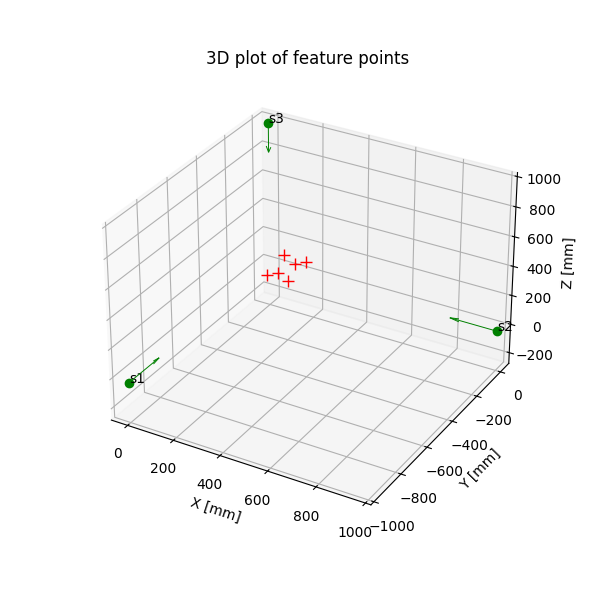

In [2]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot feature points
for label, (x,y,z) in features.items():
    ax.plot(x,y,z, "+", markersize=8, label=label, color="r")
    # ax.text(x,y,z, label)

# plot sensors
for label, sensor_pos in sensors.items():
    x, y, z = sensor_pos
    ax.plot(x,y,z, ".", markersize=12, label=label, color="g")
    ax.text(x,y,z, label)
    sensor_vec = np.zeros(3) - sensor_pos
    ax.quiver(*sensor_pos, *sensor_vec, length=0.2, linewidths=0.7, color='green', arrow_length_ratio=0.2)


# plot data points
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_title('3D plot of feature points')

ax.set_xlim([-50, C])
ax.set_ylim([-C, C-950])
ax.set_zlim([-C+750, C])

plt.show()

### observation function for lateration

In [3]:
from scipy.spatial.transform import Rotation
    
# rigid body transformation x,y,z-axis
def p1_xyz(z, alpha, w):
    # R_x = Rotation.from_euler('x', alpha[0])
    # R_y = Rotation.from_euler('y', alpha[1])
    # R_z = Rotation.from_euler('z', alpha[2])
    # return R_z.apply(R_y.apply(R_x.apply(z + w)))

    R_zyx = Rotation.from_euler('xyz', alpha)
    return R_zyx.apply(z+w)
    
# observational function of multilateration
def p2(z, alpha, w, gamma):
    u = p1_xyz(z, alpha, w)
    return np.linalg.norm(u-gamma)

### Forward model (true distances):

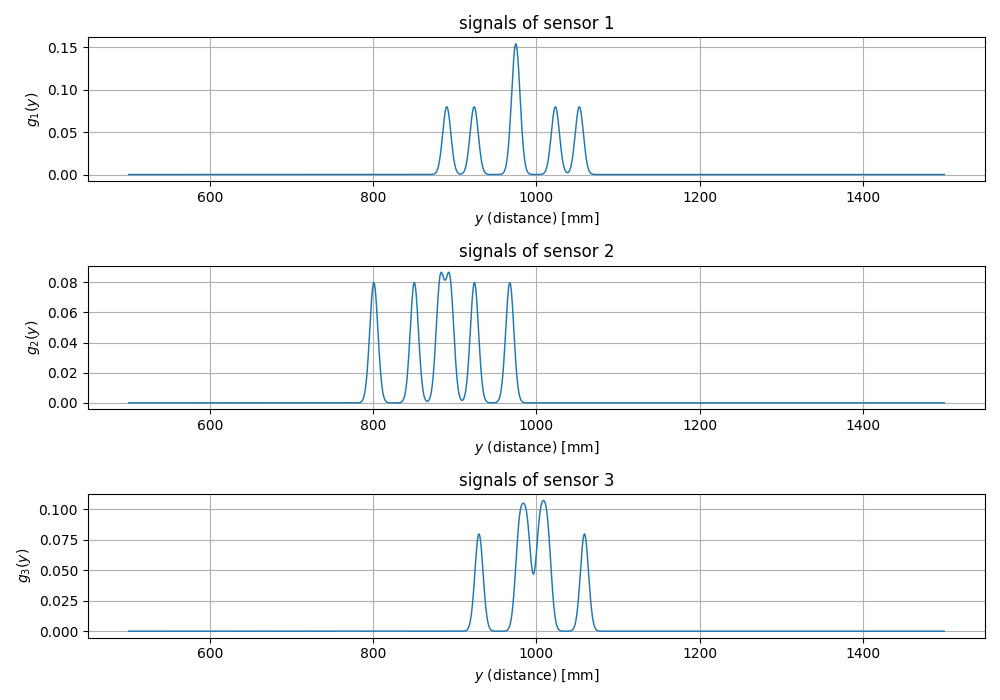

In [4]:
from scipy import interpolate

w0 = np.zeros(3)
V0 = np.zeros(3)

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(4/12)])

w0 = w0 + delta_w
V0 = V0 + alpha

points = np.array(list(features.values()))
points_new = points.copy()
    
# plot sensor data
plt.figure(figsize=(10, 7))

g_pdfs = []

for i, (slabel, sensor_pos) in enumerate(sensors.items()):

    distances = []
    for p in points_new:
        distances.append(p2(p, V0, w0, sensor_pos))

    x = np.linspace(500, 1500, 5000)
    y = np.zeros_like(x)
    sigma = 5
        
    for d in distances:
        # add a gaussian kernel for each distance
        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
        y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))

    g_pdfs.append(interpolate.interp1d(x, y, kind="cubic"))# fill_value="extrapolate")) #)  #
    
    # add a subplot for the current sensor
    plt.subplot(len(sensors), 1, i+1)
    plt.plot(x, y, linewidth=1.05)
    plt.title(f"signals of sensor {i+1}")
    plt.xlabel(fr'$y$ (distance) [mm]')
    plt.ylabel(fr'$g_{i+1}(y)$')
    plt.grid(True)

plt.tight_layout()
plt.show()


### feature coordinate mixture model

### lhsnorm

In [5]:
from scipy.stats import qmc, norm

def lhsnorm(mean, std, size):
    num_samples, dim = size

    sampler = qmc.LatinHypercube(d=dim, optimization="random-cd").random(n=num_samples)
    samples_norm = norm(loc=mean, scale=std).ppf(sampler)
    
    return samples_norm

In [6]:
def q(z, std, R, lhs_on=False):
    if lhs_on:
        z_samples = lhsnorm(z, std, size=(R, z.shape[0]))
    else:
        z_samples = np.random.normal(z, std, size=(R, z.shape[0]))
    
    if (z_samples.shape[0] == 1):
        return z_samples[0]
    
    return z_samples


In [29]:
q(np.ones(3)*5, 1, 1, lhs_on=True)

array([4.551720, 4.573908, 5.270375])

### drawing R measurements from mixture model

In [7]:
# sample measurements for each feature point

sampled_feature_pnts = {}
R = 200
std = 5
for feature_label, feature_coords in features.items():
    sampled_feature_pnts[feature_label] = q(feature_coords, std, R, lhs_on=True)

N = len(sampled_feature_pnts)

print((N, R))
sampled_feature_pnts

(6, 200)


{'p1': array([[-0.852884, -27.055857, -52.619350],
        [2.229562, -22.496589, -44.224191],
        [0.206687, -28.597350, -43.561731],
        [2.405486, -32.377573, -41.407756],
        [4.391049, -32.398624, -47.197481],
        [6.499018, -23.153115, -44.095823],
        [1.927395, -25.777997, -43.776137],
        [-2.452960, -15.783362, -39.407936],
        [-2.536747, -20.511564, -34.744677],
        [9.525226, -20.900771, -42.072014],
        [2.856999, -30.995579, -39.275745],
        [-2.178622, -26.451604, -44.928932],
        [-4.459908, -16.861378, -36.888025],
        [4.671800, -21.892174, -47.016803],
        [7.572009, -24.812606, -49.862895],
        [-6.396695, -19.939681, -43.139556],
        [-9.339887, -34.148507, -41.979400],
        [3.243521, -20.875550, -54.178047],
        [12.537652, -25.836074, -53.920669],
        [-4.183914, -21.094615, -44.712426],
        [1.135496, -27.785611, -41.010977],
        [-4.489988, -28.062998, -28.549408],
        [-1.1941

In [8]:
sensors_arr= np.array(list(sensors.values()))
sampled_features_arr = np.array(list(sampled_feature_pnts.values()))

# cost function
def f_cost(x0, *args):
    V, w = x0.reshape(2,3)
    cost_sum = 0.0
    
    # number of featrues N
    for _, samples_arr in sampled_feature_pnts.items():
        
        # number of samples per features R
        for z_vec in samples_arr:
            inner_product = 1.0
            
            # number of lateration devices L
            for sensor_idx, sensor_coords in enumerate(sensors.values()):
                inner_product *= g_pdfs[sensor_idx](p2(z_vec, V, w, sensor_coords))
                
            cost_sum += inner_product
    
    return cost_sum / (N*R)

# cost function
def f_cost_new(x0, *args):
    V, w = x0.reshape(2,3)
    cost_sum = 0.0
        
    # number of features N
    for samples_arr in sampled_features_arr:
        # number of samples per features R
        for z_vec in samples_arr:
            sensor_product = np.prod([g_pdfs[l](p2(z_vec, V, w, sensors_arr[l])) for l in range(sensors_arr.shape[0])])
            cost_sum += sensor_product
    
    return cost_sum / (N*R)

### Nelder-Mead

In [9]:
from scipy.optimize import minimize

true_pose = np.concatenate((V0, w0))

V_guess = q(V0, np.pi*(1/72), 1)
w_guess = q(w0, 5, 1)

x0 = np.concatenate((V_guess, w_guess))
alpha_opt = minimize(f_cost, x0, method='Nelder-Mead', tol=10e-9)
alpha_opt.x

print("%s"%str(true_pose))  # real pose
print(x0)                   # perturbed pose
print(alpha_opt.x)          # predicted pose
a, b = x0.reshape(2,3)

[0.000000 0.000000 -1.047198 40.000000 40.000000 40.000000]
[-0.037136 0.030965 -1.026157 35.498736 45.260519 40.735862]
[-0.129082 -0.109063 -1.134215 25.906115 76.240973 8.402617]


### Bayesian Optimization

In [29]:
# draw guess pose for inital value of optimization
true_pose = np.concatenate([V0, w0])

dV_max = np.pi*(1/72)   # 2.5 degrees
dw_max = 5              # 5 mm

V_probe = V0 + np.random.uniform(low=-dV_max, high=dV_max, size=3)
w_probe = w0 + np.random.uniform(low=-dw_max, high=dw_max, size=3)

x0_probe = np.concatenate([V_probe, w_probe])
x0_probe

array([0.028705, 0.037161, -1.032302, 35.700189, 41.078481, 44.778725])

In [35]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

# define bounds
pbounds = {}
for i in range(len(V_probe)):
    pbounds[f'V{i}'] = (V_probe[i]-dV_max, V_probe[i]+dV_max)
for i in range(len(w_probe)):
    pbounds[f'w{i}'] = (w_probe[i]-dw_max, w_probe[i]+dw_max)

bounds_transformer = SequentialDomainReductionTransformer(minimum_window=dV_max/3)

# wrapper function to convert input to numpy array
def f_cost_wrapper(V0, V1, V2, w0, w1, w2):
    return f_cost(np.array([V0, V1, V2, w0, w1, w2]))

# create optimizer object
optimizer = BayesianOptimization(f=f_cost_wrapper, pbounds=pbounds, random_state=1, bounds_transformer=bounds_transformer)
optimizer.probe(params=dict(zip(['V0', 'V1', 'V2', 'w0', 'w1', 'w2'], x0_probe)), lazy=True)
optimizer.maximize(init_points=200, n_iter=100)

best_params = optimizer.max['params']
best_alpha = np.array(list(best_params.values()))
print(best_alpha)


|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 1         | 0.0009104 | 0.0287    | 0.03716   | -1.032    | 35.7      | 41.08     | 44.78     |
| 2         | 0.0008001 | 0.02146   | 0.05639   | -1.076    | 33.72     | 37.55     | 40.7      |
| 3         | 0.001015  | 0.001326  | 0.02368   | -1.041    | 36.09     | 40.27     | 46.63     |
| 4         | 0.0009977 | 0.002913  | 0.07016   | -1.074    | 37.4      | 40.25     | 45.37     |
| 5         | 0.0008491 | -0.002678 | 0.01082   | -1.006    | 40.38     | 39.21     | 46.7      |
| 6         | 0.0005114 | 0.06155   | 0.0716    | -1.069    | 31.09     | 37.78     | 48.56     |
| 7         | 0.000401  | -0.006346 | 0.03028   | -0.9923   | 36.03     | 43.0      | 42.93     |
| 8         | 0.0009345 | 0.04498   | 0.06636   | -1.074    | 38.2      | 45.97     | 47.26     |
| 9         | 0.0009

In [36]:
print(" True:  " + str(true_pose))
print("Guess:  " + str(np.concatenate((V_probe, w_probe))) + ". RMS: " + str(np.mean(np.sqrt((x0_probe - true_pose)**2))))
print(" Best:  " + str(best_alpha) + ". RMS: " + str(np.mean(np.sqrt((best_alpha - true_pose)**2))))
print(f"Error:  {np.abs(true_pose - best_alpha)}")

 True:  [0.000000 0.000000 -1.047198 40.000000 40.000000 40.000000]
Guess:  [0.028705 0.037161 -1.032302 35.700189 41.078481 44.778725]. RMS: 1.7062964040720454
 Best:  [0.002814 -0.006472 -1.065104 38.684220 42.087837 40.528389]. RMS: 0.6598665556161685
Error:  [0.002814 0.006472 0.017907 1.315780 2.087837 0.528389]


In [37]:
# best_alpha = np.concatenate([best_V, best_w])
best_alpha_deg = np.concatenate([best_alpha[:3]*(180/np.pi), best_alpha[3:]])
true_pose_deg = np.concatenate([true_pose[:3]*(180/np.pi), true_pose[3:]])

print(" True: " + str(true_pose_deg))
print(" Best: " + str(best_alpha_deg) + ". RMS: " + str(np.mean(np.sqrt((best_alpha_deg - true_pose_deg)**2))))

 True: [0.000000 0.000000 -60.000000 40.000000 40.000000 40.000000]
 Best: [0.161212 -0.370825 -61.025993 38.684220 42.087837 40.528389]. RMS: 0.9150060749612378


In [ ]:
import numpy as np
from scipy.optimize import minimize

def approximate_gradient(f, x, h_rad=np.pi*(1/144), h_mm=1e-3):
    """
    Approximate the gradient of the cost function f at point x.
    """
    grad = np.zeros_like(x)
    for i in range(3):
        x_plus_h = np.copy(x)
        x_plus_h[i] += h_rad
        grad[i] = (f(x_plus_h) - f(x)) / h_rad
        
    for i in range(3, 6):
        x_plus_h = np.copy(x)
        x_plus_h[i] += h_mm
        grad[i] = (f(x_plus_h) - f(x)) / h_mm
        
    return grad

def quasi_newton_method(f, x0, tol=1e-5, max_iter=100):
    """
    Quasi-Newton optimization using BFGS.
    """
    # wrapper for gradient approximation
    def grad_approx(x):
        return approximate_gradient(f, x)
    
    res = minimize(f, x0, method='L-BFGS-B', jac=grad_approx, options={'gtol': tol, 'maxiter': max_iter, 'disp': True})
    # res = minimize(f, x0, method='BFGS', options={'gtol': tol, 'maxiter': max_iter, 'disp': True, 'eps':np.array([0.01, 0.01, 0.01, 0.1, 0.1, 0.1])})
    
    return res

res_bfgs = quasi_newton_method(f_cost, best_alpha)

print("Optimization Result:")
print("Location of Minimum:", res_bfgs.x)
print("Minimum Value:", res_bfgs.fun)


In [27]:
best_opt_deg = np.round(np.concatenate([res_bfgs.x[:3]*(180/np.pi), res_bfgs.x[3:]]), 9)

print(" True: " + str(true_pose_deg))
print(" Best: " + str(best_alpha_deg) + ". RMS: " + str(np.mean(np.sqrt((best_alpha_deg - true_pose_deg)**2))))
print("  Opt: " + str(best_opt_deg) + ". RMS: " + str(np.mean(np.sqrt((best_opt_deg - true_pose_deg)**2))))

 True: [0.000000 0.000000 -60.000000 40.000000 40.000000 40.000000]
 Best: [0.126715 -1.185394 -61.123486 38.287018 41.754968 38.745977]. RMS: 1.1929280466704608
  Opt: [17.171101 11.698188 -21.154021 38.289013 41.751294 38.749544]. RMS: 12.071334089333334


In [ ]:
# test plot of cost function

k=2
# for k in range(3):

# define ranges for V0 and w0
V_range = np.linspace(-2.5, 2.5, 50)
w_range = np.linspace(-50, 150, 50)

# initialize cost surface
cost_surface = np.zeros((len(V_range), len(w_range)))
V, w = V0.copy(), w0.copy()
x0 = np.concatenate((V, w))

# calculate the cost for each combination of V0 and w0
for i, V_ in enumerate(V_range):
    for j, w_ in enumerate(w_range):
        x0[k], x0[k+3] = V_, w_
        cost_surface[i, j] = f_cost(x0)

# from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

# interp_func = interp2d(V_range, w_range, cost_surface.T, kind='cubic')
interp_func = RegularGridInterpolator((V_range, w_range), cost_surface, bounds_error=False, fill_value=None)
alpha_opt_z = interp_func((alpha_opt.x[:3][k], alpha_opt.x[3:][k]))
res_bfgs_z = interp_func((res_bfgs.x[:3][k], res_bfgs.x[3:][k]))
true_pose_z = interp_func((true_pose[:3][k], true_pose[3:][k]))
bayes_z = interp_func((best_alpha[:3][k], best_alpha[3:][k]))

# plotting the cost surface
V_mesh, w_mesh = np.meshgrid(V_range, w_range)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(alpha_opt.x[:3][1], alpha_opt.x[3:][1], alpha_opt_z, color='red', s=100, marker='x')
# ax.scatter(true_pose[:3][1], true_pose[3:][1], true_pose_z, color='green', s=100, marker='x')
ax.plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
ax.plot(res_bfgs.x[:3][k], res_bfgs.x[3:][k], res_bfgs_z, color='black', marker='x', markersize=10, zorder=100)
ax.plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)
ax.plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, color='cyan', marker='x', markersize=10, zorder=100)

ax.plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis')

ax.set_xlabel('V')
ax.set_ylabel('w')
ax.set_zlabel('Cost Sum')
ax.view_init(azim=-90, elev=90)
plt.title('Cost Function')

plt.show()

In [13]:
# from scipy.interpolate import interp2d

# fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(18, 6))

# for k in [0, 1, 2]:

#     # define ranges for V0 and w0
#     Vk_range = np.linspace(-2.5, 2.5, 50)
#     wk_range = np.linspace(-50, 150, 50)

#     # initialize cost surface
#     cost_surface = np.zeros((len(Vk_range), len(wk_range)))

#     # calculate cost for each combination of V0 and w0
#     for i, Vk_ in enumerate(Vk_range):
#         for j, wk_ in enumerate(wk_range):
#             V, w = V0.copy(), w0.copy()
#             V[k], w[k] = Vk_, wk_

#             x0 = np.concatenate((V, w))
#             cost_surface[i, j] = f_cost(x0)

#     # interpolate markers
#     interp_func = interp2d(Vk_range, wk_range, cost_surface.T, kind='cubic')
#     # alpha_opt_z = interp_func(alpha_opt.x[:3][k], alpha_opt.x[3:][k])[0]
#     true_pose_z = interp_func(true_pose[:3][k], true_pose[3:][k])[0]
#     bayes_z = interp_func(best_alpha[:3][k], best_alpha[3:][k])[0]
    
    
#     # plot cost surface
#     V_mesh, w_mesh = np.meshgrid(Vk_range, wk_range)
#     axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

#     # plot markers
#     # axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
#     axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)
#     axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, color='cyan', marker='x', markersize=10, zorder=100)

#     axes[k].set_xlabel('V')
#     axes[k].set_ylabel('w')
#     axes[k].set_zlabel('Cost Sum')
#     axes[k].set_title(f'Cost Function for k={k}')

# plt.tight_layout()
# plt.show()

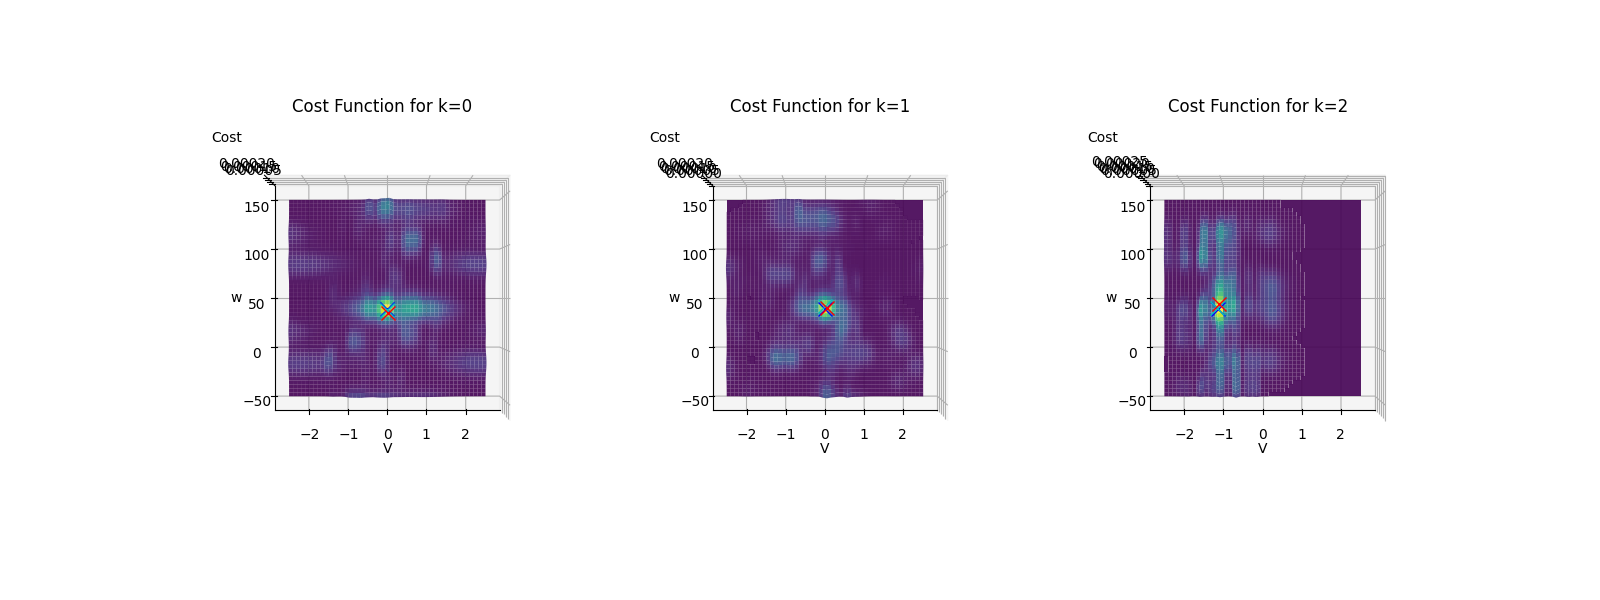

In [38]:
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Process, Queue

# reduced and slightly blurred sampling for surface plots
sampled_features_surf = {}
R = 50
std = 6
for feature_label, feature_coords in features.items():
    sampled_features_surf[feature_label] = q(feature_coords, std, R, lhs_on=True)

N = len(sampled_feature_pnts)

# cost function for surface plot using reduced samples
def f_cost_surf(x0, *args):
    V, w = x0.reshape(2,3)
    cost_sum = 0.0
    
    # number of featrues N
    for _, samples_arr in sampled_features_surf.items():
        
        # number of samples per features R
        for z_vec in samples_arr:
            inner_product = 1.0
            
            # number of lateration devices L
            for sensor_idx, sensor_coords in enumerate(sensors.values()):
                inner_product *= g_pdfs[sensor_idx](p2(z_vec, V, w, sensor_coords))
                
            cost_sum += inner_product
    
    return cost_sum / (N*R)

# computes cost surface for given k
def compute_cost_surface(k, V0, w0, f_cost, alpha_opt, true_pose, best_alpha, guess, output):
    V_range = np.linspace(-2.5, 2.5, 50)
    w_range = np.linspace(-50, 150, 50)

    # initialize cost surface
    cost_surface = np.zeros((len(V_range), len(w_range)))
    V, w = V0.copy(), w0.copy()
    x0 = np.concatenate((V, w))

    # calculate cost for each combination of V0 and w0
    for i, V_ in enumerate(V_range):
        for j, w_ in enumerate(w_range):
            x0[k], x0[k+3] = V_, w_
            cost_surface[i, j] = f_cost_surf(x0)

    # interp_func = interp2d(V_range, w_range, cost_surface.T, kind='cubic')
    interp_func = RegularGridInterpolator((V_range, w_range), cost_surface, bounds_error=False, fill_value=None)
    
    # alpha_opt_z = interp_func((alpha_opt.x[:3][k], alpha_opt.x[3:][k]))
    true_pose_z = interp_func((true_pose[:3][k], true_pose[3:][k]))
    bayes_z = interp_func((best_alpha[:3][k], best_alpha[3:][k]))
    guess_z = interp_func((guess[:3][k], guess[3:][k]))

    # put results in output queue
    output.put((k, cost_surface, None, true_pose_z, bayes_z, guess_z))

# create queue to share results
output = Queue()
processes = []

for k in range(3):
    p = Process(target=compute_cost_surface, args=(k, V0, w0, f_cost, None, true_pose, best_alpha, x0_probe, output))
    processes.append(p)
    p.start()

# wait for processes to complete
for p in processes:
    p.join()

results = [output.get() for _ in range(3)]


# plot results
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(16, 6))
for result in sorted(results):
    k, cost_surface, alpha_opt_z, true_pose_z, bayes_z, guess_z = result
    
    # interpolate and plot cost surface
    V_range = np.linspace(-2.5, 2.5, 50)
    w_range = np.linspace(-50, 150, 50)
    V_mesh, w_mesh = np.meshgrid(V_range, w_range)
    axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

    # plot markers
    # axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, 'rx', markersize=10, zorder=5)
    axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, 'bx', markersize=10, zorder=5)
    axes[k].plot(best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=10, zorder=5)
    axes[k].plot(x0_probe[:3][k], x0_probe[3:][k], guess_z, 'rx', markersize=10, zorder=5)

    axes[k].set_xlabel('V')
    axes[k].set_ylabel('w')
    axes[k].set_zlabel('Cost')
    axes[k].set_title(f'Cost Function for k={k}')
    axes[k].view_init(azim=-90, elev=90)
plt.show()


### Metrics

In [12]:
# convert to degrees
neldm_pose = np.concatenate([alpha_opt.x[:3]*(180/np.pi), alpha_opt.x[3:]])
true_pose = np.concatenate([true_pose[:3]*(180/np.pi), true_pose[3:]])
bayes_pose = np.concatenate([best_alpha[:3]*(180/np.pi), best_alpha[3:]])

In [ ]:
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.4f}".format(x)})

print(f'true pose:   {true_pose}')
print(f'nelder mead: {neldm_pose}')
print(f'bayes: {bayes_pose}')
radar_plot(neldm_pose, true_pose)
radar_plot(bayes_pose, true_pose)
# print()
# true_pose[:3][k], true_pose[3:][k], true_pose_z, 'mx', markersize=10, zorder=5)
# best_alpha[:3][k], best_alpha[3:][k], bayes_z, 'cx', markersize=10, zorder=5)
